# Flow Processing Pipeline


## Who has not work on this pipeline?
- Ayush
- Yanda
- Daniel

## To do Edson:
- save time as "14:00" and not "14:0"

## Goal of the pipeline

The goal of this notebook is to associate the raw ADT ground-data for 2013, 2015, 2017 and 2019, and the raw speed ground-data in 2015 to the Aimsun network for the calibration of Aimsun simulations. First the raw data is processed in a common format, then, every detector is associated with a network link inside Aimsun. Later, every detector is associated with a road section to create heatmap and understand the evolution of flows over years. </font>


### Outputs of the pipeline: 
- One file matching detectors location to Aimsun road section
- Two files with the processed flow data for 2013, 2015, 2017, 2019 (one for the city and one for PeMS)
- One file with the processed speed data for 2015
- One file with the flow data corresponding to road sections for 2013, 2015, 2017 and 2019
- PCA on flow data

### Inputs of the pipeline: 
**Raw data**
- PeMS account [_publicly available_]. Can be created in http://pems.dot.ca.gov
- PeMS detectors location [_publicly available_]. In the dropbox under `Demand/Flow_speed/Traffic\ flow\ studies/PeMS`
- City average annual daily traffic (AADT) data for 2013, 2017 and 2019 [_given by the city of Fremont_]. Located in the dropbox under `Demand/Flow_speed/Traffic\ flow\ studies/City`
- Kimley-Horn flow and speed data for 2015 [_given by the city of Fremont_]. Located in the dropbox under `Demand/Flow_speed/Traffic\ flow\ studies/Kimley\ Horn\ Data`

**Manually made dataset**
- Aimsun network
- Detectors location
- Road section layer
- Doc files or city ADT data corresponding to the PDF files


### Temporary files of the pipeline
- CSV flow data
    - City and Kimley Horn
    - PeMS data
- geographic information of road detectors for 2013, 2015, 2017, 2019

### Dependent scripts: 
- [pems_download.py](https://github.com/Fremont-project/data-processing/blob/master/pipeline/flow/pems_download.py): the script automatically download PeMs data for chosen date.
- [pre_process_flow.py](https://github.com/Fremont-project/data-processing/blob/master/pipeline/flow/pre_process_flow.py): the script (A). parse the ADT data from xlsx, doc and csv files to csv files (B). Find the coordinates of the city detectors (C). Check and adjust the locations of the (City + PeMS) detectors to match them to our network using ArcGIS 
- [process_flow.py](https://github.com/Fremont-project/data-processing/blob/master/pipeline/flow/process_flow.py): this script processes all the flow traffic data into one big CSV file from both city and PeMS data files
- [process_years_together.py](https://github.com/Fremont-project/data-processing/blob/master/pipeline/flow/process_years_together.py): this script combines the previous scripts and processes the data for 2013, 2015, 2017, 2019
- [fremontdropbox](https://github.com/Fremont-project/data-processing/blob/master/fremontdropbox.py): 

### Dependent libraries:
- os
- sys
- webbrowser
- time
- requests
- pathlib.Path
- textract
- [numpy](https://numpy.org)
- datetime
- pandas
- math
- requests
- glob
- csv
- re
- spatialindex
- Rtree
- osmnx
- keplergl
- shapely
- sklearn

### Work done by the script
1. Obtaining Data
    - Turn city pdf to doc
    - PeMS data download
2. Parsing and processing city and Kimley-Horn data
    - Parsing the flow data
    - Parsing the speed data
3. Processing the data
    - Creating one file with the flow for all detectors
    - Geocoding location of the detectors
4. Matching detectors to Aimsun road sections
    - Manually update the location of the detectors
    - Matching the detectors with the corresponding road section in Aimsun
5. Comparing evolution of flow over year
    - Creating a layer of road section
    - Matching the detectors to road section
    - Creating one file with the flow over time for every road section
6. Exporting the data
    - Exporting a csv file where Aimsun road sections are matched with detectors
    - Exporting a csv file with flow for the different detectors
    - Exporting traffic flow heatmap
    - Exporting speed heatmap
    - PCA on the traffic flow heatmap over years

In [1]:
import sys
import os
import platform

# auto reloads modules when editing a python file
%load_ext autoreload
%autoreload 2

# We let this notebook to know where to look for fremontdropbox module
module_path = os.path.abspath(os.path.join('../..'))
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)

# from fremontdropbox import get_dropbox_location
# dropbox_dir = get_dropbox_location()

system = platform.system()
if 'Windows' == system:
    dropbox_dir = os.path.join(os.path.join(os.environ['USERPROFILE']), 'Dropbox/') 
else:
    dropbox_dir = os.path.join(os.path.join(os.path.expanduser('~')), 'Dropbox/')
print(dropbox_dir)


/Users/edson/Desktop/lab/github/data-processing
/Users/edson/Dropbox/


## 1. Obtaining Data

### A) Turn city pdf to doc

Some of the flow data that we got from the city were in pdf files. To be able to parse them, we convert them to doc files using online website. This should be done before running the code. The doc files are inputs of the pipeline.
This has been done manually, and is not part of the pipeline.

### B) PeMS Data Download 
    
Script: pems_download.py <br>
Download traffic data from the PEMS website (pews.dot.ca.gov) for years 2013, 2015, 2017 and 2019 <br>

We download the data calling the method download(detector_ids, year, PeMS_dir) from the pems_download.py file. The process takes about 20 minutes to run. 
Run `print(help(pems.download))` to get some help.

In [3]:
import pems_download as pems
# print(help(pems.download))

In [4]:
# ************* IMPORTANT *************
# --> For this cell to work, you need to log in to PeMS in the same browser that runs this Jupyter notebook

## The IDs of the PeMS detectors where obtained using ArcGIS software and an input file, pems_detectors.csv, containing the locations of all the PeMS dectectors in California
## this should be done in Python!
detector_ids = [403250, 403256, 403255, 403257, 418387, 418388, 400376,
               413981, 413980, 413982, 402794, 413983, 413984, 413985,
               413987, 413986, 402796, 413988, 402799, 403251, 403710,
               403254, 403719, 400566, 418420, 418419, 418422, 418423,
               402793, 403226, 414015, 414016, 402795, 402797, 414011,
               402798]
PeMS_dir = dropbox_dir + '/Private Structured data collection/Data processing/Auxiliary files/Demand/Flow_speed/PeMS'

# for year in [2013, 2015, 2017, 2019]:
#     pems.download(year, detector_ids, PeMS_dir)

In [5]:
for year in [2013, 2015, 2017, 2019]:
    pems.PeMS_tester(year, PeMS_dir, True)

PeMS during 03/05/2013 00:00:00-03/07/2013 23:59:59
PeMS during 03/03/2015 00:00:00-03/05/2015 23:59:59
PeMS during 03/07/2017 00:00:00-03/09/2017 23:59:59
PeMS during 03/05/2019 00:00:00-03/07/2019 23:59:59


## 2. Parsing and processing city data


### Parsing city and Kimley Horn flow data from xlsx, doc and csv files to csv files

Here, we process the Excel and PDF ADT data files (city data) into CSV files.

- run `print(help(pre_process.parse_excel_2013)` to get some help for 2013 excel files
- run `print(help(pre_process.parse_excel_2015)` to get some help for 2015 excel files
- run `print(help(pre_process.parse_excel_2017)` to get some help for 2017 excel files
- run `print(help(pre_process.parse_excel_2019)` to get some help for 2019 excel files
- run `print(help(pre_process.parse_adt_as_file)` to get some help for the 2017 and 2019 doc files

In [4]:
import pre_process_flow as pre_process
print(help(pre_process.process_adt_data))

Help on function process_adt_data in module pre_process_flow:

process_adt_data(year, Processed_dir, Input_dir)
    This function processes the Excel and PDF ADT data files (city data) into CSV files. Note that one file corresponds to one main road and the traffic flow data recordings in it.
    
    This function has input:
        - year which takes values 2013, 2015, 2017 or 2019
        - Processed_dir: path to the output
        - Input_dir: path to the inputs
    
    The function has output:
        - CSV files located in the Processed_dir/Year_processed/ folder where Year=2017 or 2019
    
    For the function to work:
        - Files should be located in 
            1. Input_dir/Year\ EXT/ folder if Year=2013, 2017 or 2019 where:
                a. Year=2013, 2017 or 2019 if Ext=ADT Data 
                b. Year=2017 or 2019 if Ext=doc for 2017 and 2019
            2. Input_dir/Raw\ data/ folder if Year=2015

None


In [8]:
print(help(pre_process.parse_excel_2013))
print(help(pre_process.parse_excel_2015))
print(help(pre_process.parse_excel_2017))
print(help(pre_process.speed_data_parser))
print(help(pre_process.parse_adt_as_file))
print(help(pre_process.parse_adt_as_file))

Help on function parse_excel_2013 in module pre_process_flow:

parse_excel_2013(dfs)
    ***2013 Excel files*** are structured in data sheets. The first data sheet "Summary" contains the main road, cross streets, city information and the start date of the recording. It also summarizes the data contained in all other sheets into a bar plot of traffic flow vs time of day bins (i.e Tuesday AM, Wednesday PM) for different flow directions and into a line plot of traffic flow vs. hour of day for different days of the week. The sheets that follow are named "D1", "D2",..."DN" where N denotes the N'th day since the start date. These sheets are structured into two tables, AM counts and PM counts. Each table row gives the traffic flow per timestep of 15 minutes. The first column is the time of day in hh:mm format follow by direction columns of traffic flow (NB, SB, EB, WB).

None
Help on function parse_excel_2015 in module pre_process_flow:

parse_excel_2015(dfs)
    ***2015 Excel files***. The f

In [6]:
ADT_dir = dropbox_dir + '/Private Structured data collection/Data processing/Raw/Demand/Flow_speed'
Processed_dir = dropbox_dir + '/Private Structured data collection/Data processing/Auxiliary files/Demand/Flow_speed/Flow_processed'
City_dir = ADT_dir + "/City"
Kimley_Horn_flow_dir = ADT_dir + "/Kimley Horn Data"

# # Preprocess 2013, 2015, 2017 and 2019 flow data
# for year in [2013, 2017, 2019]:
#     pre_process.process_adt_data(year, Processed_dir, City_dir)

# pre_process.process_adt_data(2015, Processed_dir, Kimley_Horn_flow_dir)
## Preprocess 2015 speed data
# pre_process.speed_data_parser(Kimley_Horn_flow_dir, Processed_dir)

In [23]:
#test the elibility of the doc files in 2017 and 2019. 
pre_process.doc_file_tester(City_dir, [2017, 2019])

Doc files are all good for both 2017 and 2019!


## 3. Matching detectors to Aimsun road section

For each detector find the closes road section in the Aimsum network. This is done by loading the detector's and aimsum network's geographical location from .shp files and for each detector (or point in the geographical space) we find the closest road section in the network. The visualization of the detectors and the road network are done in Kepler.

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plot
from shapely import wkt
import keplergl as kp
import spatial_join as sj

In [3]:
print(help(sj.detectors_to_road_segments))


Creating detectors_to_road_segments_2013.csv
number of road segments 5626
number of detectors 59
Detectors w/out road assignment found, with search radius of 0.0001
Writing detectors_without_road_segments_2013.csv

Finding detector to road duplicates for 2013
No duplicates found

Creating detectors_to_road_segments_2015.csv
number of road segments 5626
number of detectors 30
Detectors w/out road assignment found, with search radius of 0.0001
Writing detectors_without_road_segments_2015.csv

Finding detector to road duplicates for 2015
No duplicates found

Creating detectors_to_road_segments_2017.csv
number of road segments 5626
number of detectors 56
Detectors w/out road assignment found, with search radius of 0.0001
Writing detectors_without_road_segments_2017.csv

Finding detector to road duplicates for 2017
No duplicates found

Creating detectors_to_road_segments_2019.csv
number of road segments 5626
number of detectors 56

Finding detector to road duplicates for 2019
No duplicates

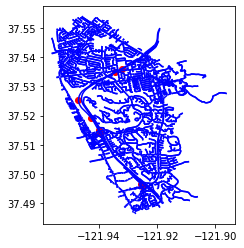

In [3]:
# directories to detectors and aimsum sections shape files
data_process_folder = dropbox_dir + "/Private Structured data collection/Data processing/"
detectors_folder = data_process_folder + "Raw/Demand/Flow_speed/Detectors/"
sections_folder = data_process_folder + "Raw/Network/Aimsun/"
output_folder = data_process_folder + "Auxiliary files/Network/Infrastructure/Detectors/"

for type_year in [2013, 2015 , 2017, 2019, 'pems']:
    # find closest road segment for each detector
    # results written to a csv per year named: detectors_to_road_segments_year.csv
    sj.detectors_to_road_segments(type_year, sections_folder, detectors_folder, output_folder)
    
    # Find duplicates. That is, multiple detectors are closest to one road, if any.
    # results if any written to a csv per year named: duplicates_year.csv
    sj.find_duplicates(type_year, sections_folder, detectors_folder, output_folder, show_plot=True)


## 4. Process city and PeMS data

We compile flow data of multiple years into one csv per type (city or PeMS). Hence the file flow_processed_city.csv contains city flow data for all years=(2013, 2015, 2017, 2019) and the file flow_processed_pems.csv contains PeMS flow data for all years as well. We also create year_info.csv files where year takes on values as given before and contains geographical data (latitude, longitude) of the city detectors. Description of what the files look like are given below:

Flow_processed_city.csv looks like:

| Name | Direction | Detector_Id | Road_Id | year | Day 1 | Day 1 - 0:0 | Day 1 - 0:15 | Day 1 - 0:30 | ... | Day 3 - 23:45 |
|------|------|------|------|------|------|------|------|------|------|------|
| Auto Mall Pkwy betw. Fremont & I680.csv | EB | 201301 | 707 |2013 | 2/12/13 | 20 | 27 | 13 | ... | 13 |
| Auto Mall Pkwy betw. Fremont & I680.csv | WB | 201302 | 505 |2013 | 2/12/13 | 36 | 25 | 18 | ... | 13 |

Flow_processed_pems.csv looks like:

| Year | Name | Detector_Id | Road_Id | %Observed | Day 1 | Day 1 - 0:0 | ... | Day 3 - 23:45 |
|------|------|------|------|------|------|------|------|------|
| 2013 | PeMS Detector 403256 | 403256 | 122 | 0 | 3/5/13 0:00 | 0 | ... | 13 |
| 2013 | PeMS Detector 418388 | 418388 | 121 | Did not exist in 2013 | X | . | ... | . |

Year_info.csv looks like:

| Name | City | Detector_Id | Main road | Cross road | Start lat | Start lng | End lat | End lng |
|------|------|------|------|------|------|------|------|------|
|Paseo Padre Pkwy Bet. Washington Blvd & Durham Rd | Fremont | 201301 | Paseo Padre Pkwy | Washington Blvd & Durham Rd | 37.5316567 | -121.9342 | 37.5142565 | -121.9311615 |
| Washington Blvd Bet. Paseo Padre Pkwy & Mission Blvd | Fremont | 201303 | Washington Blvd | Paseo Padre Pkwy & Mission Blvd | 37.5316567 | -121.9342 | 37.5334051 | -121.9200877 |

In [4]:
import pre_process_flow as pre_process

data_process_folder = dropbox_dir + "/Private Structured data collection/Data processing/"
raw_2013_city_folder = data_process_folder + "Raw/Demand/Flow_speed/City/2013 ADT Data/"
detectors_to_roads_folder = data_process_folder + "Auxiliary files/Network/Infrastructure/Detectors/"
flow_speed_folder = data_process_folder + "Auxiliary files/Demand/Flow_speed/"
processed_city_folder = flow_speed_folder + "Flow_processed/"
processed_pems_folder = flow_speed_folder + "PeMS/"

# creates flow_processed_city.csv and year_info.csv for year=2013, 2015, 2017 and 2019
output_folder = processed_city_folder
pre_process.flow_processed_generator_city(processed_city_folder, output_folder, raw_2013_city_folder,
                                         detectors_to_roads_folder)

# creates flow_processed_pems.csv
output_folder = processed_pems_folder
pre_process.flow_processed_generator_pems(processed_pems_folder, output_folder, 
                                          detectors_to_roads_folder)

# update speed data files with detector ids and road ids (ids are result of step 3. spatial join)
pre_process.speed_processed_update(processed_city_folder)

# creates flow_processed_year.csv where year=2013, 2015, 2017 and 2019 containing both city and pems data
# These are ouput files for the aimsum team
output_folder = flow_speed_folder
pre_process.create_aimsum_flow_processed_files(flow_speed_folder, output_folder)

Creating flow_processed_city.csv
Creating 2013_info.csv
Creating 2015_info.csv
Creating 2017_info.csv
Creating 2019_info.csv
Creating flow_processed_pems.csv
Creating flow_processed_2013.csv
Creating flow_processed_2015.csv
Creating flow_processed_2017.csv
Creating flow_processed_2019.csv
Creating aimsum_flow_processed_2013.csv
Creating aimsum_flow_processed_2015.csv
Creating aimsum_flow_processed_2017.csv
Creating aimsum_flow_processed_2019.csv


## 5. Exporting all the data

Data export files of interest are:
- __detectors_to_road_segments_year.csv__: <br>
    is a data file where detectors are matched to their closest road segment in the aimsum network. The file has columns "Detector_Id" and "eid" (which is a road segment id). Note that each row in the file is a match. Also, year takes on values (2013, 2014, 2015, 2019) hence there are 4 files, one per year. This file is located in: "Private Structured data collection/Data processing/Temporary exports to be copied to processed data/Network/Infrastructure".

- __flow_processed_year.csv__: <br>
    is a data file where rows are flow data for a given road segment and day where the day is counted in 15 minute timesteps. It has columns "Name", "Id", "Year", and multiple "timestep"'s where timestep takes values from 0:0, 0:15, 0:30..., 23:45. Note that "Id" is the detector id assigned in detectors_to_road_segments_year.csv. Also, same as before year takes on values (2013, 2014, 2015, 2019) hence there are 4 files. The data contains both city and flow data. This file is located in: "Private Structured data collection/Data processing/Temporary exports to be copied to processed data/Demand/Flow_speed".

## To do:
- copy relevant files from `Auxiliary files/Demand/Flow_speed/` to `Temporary exports to be copied to processed data/Demand/Flow_speed/`

Relevant files =
- aimsum_flow_processed_YEAR.csv
- detectors_to_road_segments_YEAR.csv
- flow_processed_YEAR.csv ???
- 2015_Speed_Processed_Num.csv ???
- 2015_Speed_Processed_Percent.csv ???

To make sure:
Before running this cell, `Temporary exports to be copied to processed data/Demand/Flow_speed/` should be empty

In [5]:
from shutil import copyfile

data_process_folder = dropbox_dir + "Private Structured data collection/Data processing/"
output_folder = data_process_folder + "Temporary exports to be copied to processed data/Demand/Flow_speed/"

# move flow data of aimsum and flow_processed
flow_folder = data_process_folder + "Auxiliary files/Demand/Flow_speed/"
years = ["2013", "2015", "2017", "2019"]
for year in years:
    file = "aimsum_flow_processed_%s.csv" % year
    copyfile(flow_folder + file, output_folder + file)
    file = "flow_processed_%s.csv" % year
    copyfile(flow_folder + file, output_folder + file)

# move 2015 Kimley speed data
speed_folder = flow_folder + "Flow_processed/"
copyfile(speed_folder + "2015_Speed_Processed_Num.csv", output_folder + "2015_Speed_Processed_Num.csv")
copyfile(speed_folder + "2015_Speed_Processed_Percent.csv", output_folder + "2015_Speed_Processed_Percent.csv")

# move spatial join results
spatial_folder = data_process_folder + "Auxiliary files/Network/Infrastructure/Detectors/"
years = ["2013", "2015", "2017", "2019", "pems"]
for year in years:
    file = "detectors_to_road_segments_%s.csv" % year
    copyfile(spatial_folder + file, output_folder + file)


print("\nAll data can be found in: " + output_folder)


All data can be found in: /Users/edson/Dropbox/Private Structured data collection/Data processing/Temporary exports to be copied to processed data/Demand/Flow_speed/


## 6. Comparing evolution of flow over years

In [6]:
import spatial_join as sj
import process_years_together as pyt

# Task 1
data_process_folder = dropbox_dir + "/Private Structured data collection/Data processing/"
streetline_folder = data_process_folder + "Raw/Demand/Flow_speed/Road section/"
detectors_folder = data_process_folder + "Raw/Demand/Flow_speed/Detectors/"
output_folder = data_process_folder + "Auxiliary files/Network/Infrastructure/Detectors/"

# Create lines_to_detectors.csv in output_folder
sj.streetlines_to_detectors(streetline_folder, detectors_folder, output_folder)    

# Task 2
# Create flow_processed_section.csv in output folder using lines_to_detectors.csv and 
# flow_processed_city.csv and flow_processed_pems.csv located in flow speed folder
flow_speed_folder = data_process_folder + "Auxiliary files/Demand/Flow_speed/"
pyt.create_flow_processed_section(output_folder, flow_speed_folder, output_folder)


Creating lines_to_detectors.csv file

Creating flow_processed_section.csv


## 7. PCA Analysis

number of road sections 88
number of road sections after nan drop 57
individual variance explained by PCs
 [64.7 11.6  6.4  3.8  2.4  2.   1.7  0.8  0.8  0.6  0.5  0.4  0.4  0.3
  0.3  0.3  0.2  0.2  0.2  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0. ]
cumulative variance explained by PCs
 [64.7 76.3 82.7 86.5 88.9 90.9 92.6 93.4 94.2 94.8 95.3 95.7 96.1 96.4
 96.7 97.  97.2 97.4 97.6 97.7 97.8 97.9 98.  98.1 98.2 98.3 98.4 98.5
 98.6 98.7 98.8 98.9 99.  99.1 99.2 99.3 99.4 99.5 99.6 99.6 99.6 99.6
 99.6 99.6 99.6 99.6 99.6 99.6 99.6 99.6 99.6 99.6 99.6 99.6 99.6 99.6
 99.6]


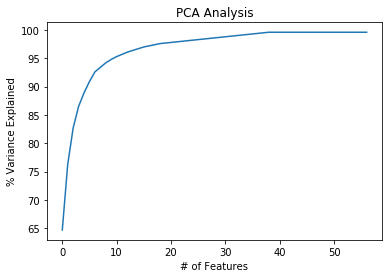

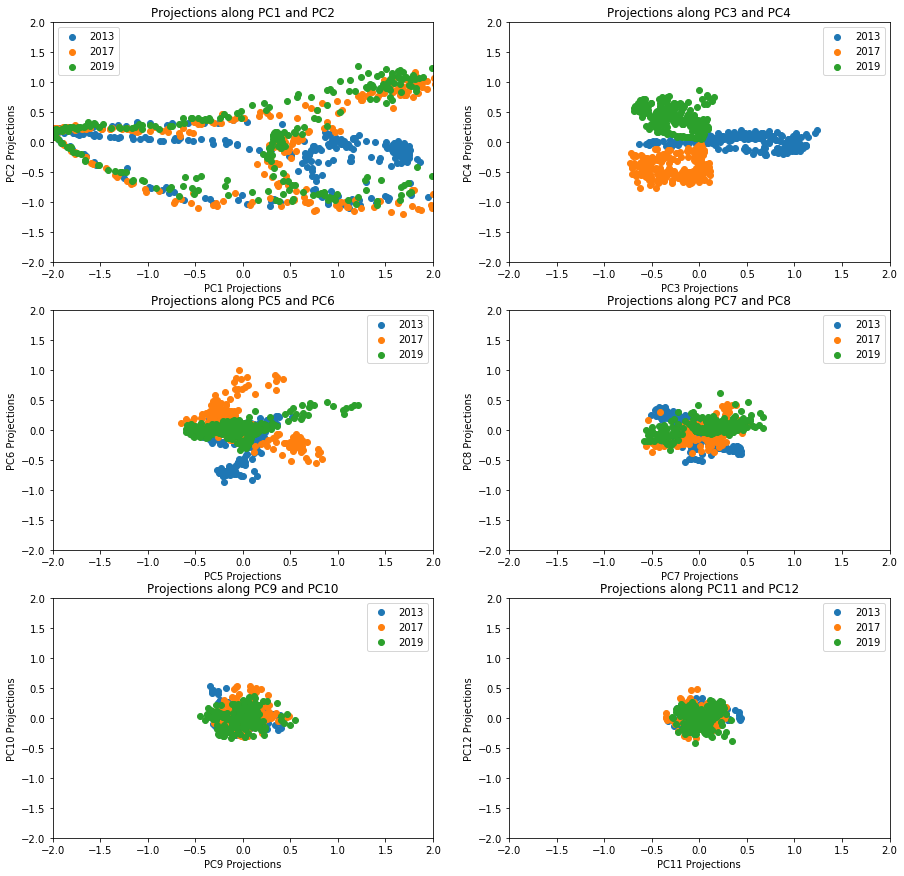

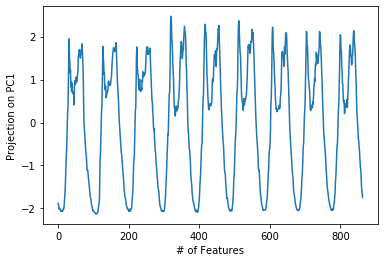

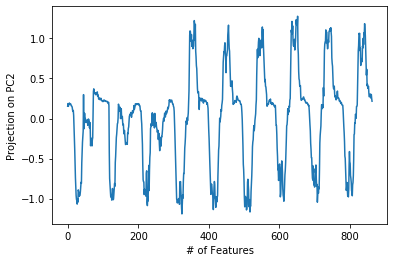

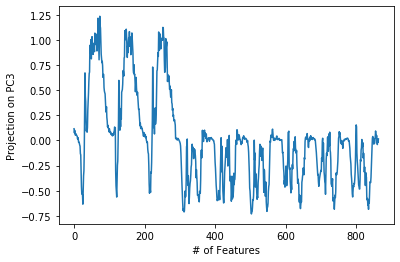

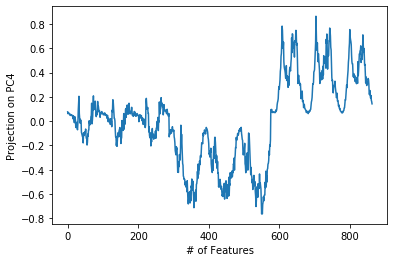

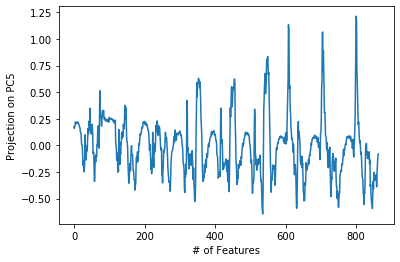

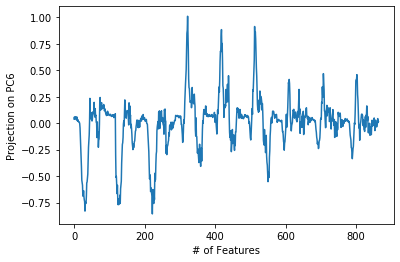

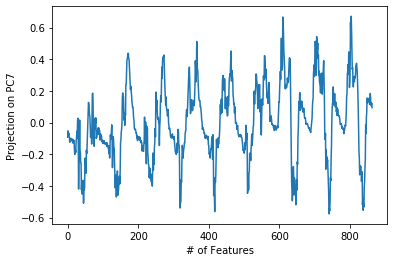

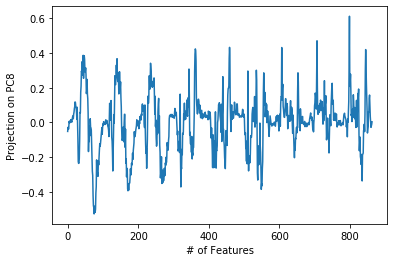

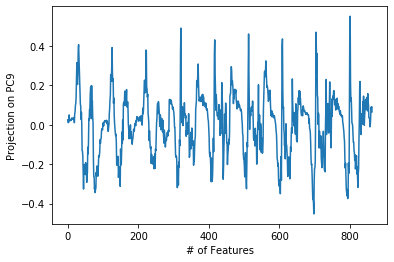

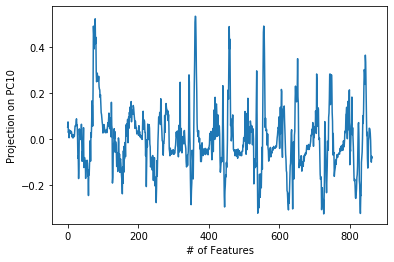

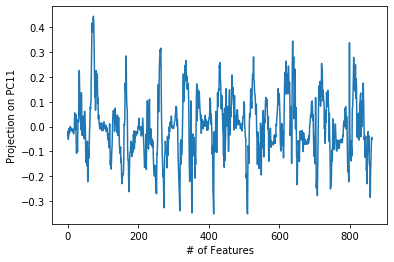

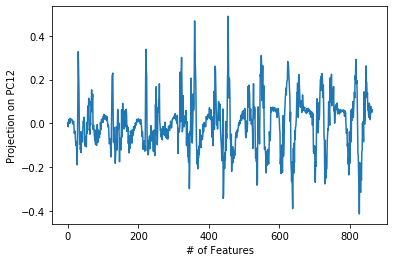

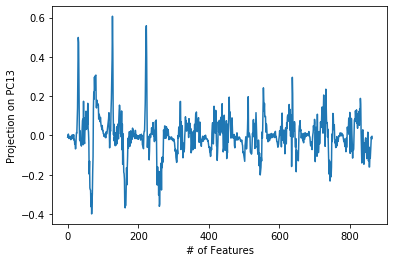

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md
Map saved to /Users/edson/Dropbox/Private Structured data collection/Data processing/Kepler maps/Demand/Flow_speed/PCA/pca_heatmap.html!
User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md
Map saved to /Users/edson/Dropbox/Private Structured data collection/Data processing/Kepler maps/Demand/Flow_speed/PCA/2013_flow_4pm_heatmap.html!
User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md
Map saved to /Users/edson/Dropbox/Private Structured data collection/Data processing/Kepler maps/Demand/Flow_speed/PCA/2015_flow_4pm_heatmap.html!
User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md
Map saved to /Users/edson/Dropbox/Private Structured data collection/Data processing/Kepler maps/Demand/Flow_speed/PCA/2017_flow_4pm_heatmap.html!
User Guide: https://github.com

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import math
import geopandas as gpd
import keplergl as kp
import json
import warnings

# surpress runtime warnings
warnings.filterwarnings('ignore')

# preset heatmap configurations
heatmap_pca_config = {'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'emx2z1b', 'type': 'geojson', 'config': {'dataId': 'PC1', 'label': 'PC1', 'color': [241, 92, 23], 'columns': {'geojson': 'geometry'}, 'isVisible': True, 'visConfig': {'opacity': 0.8, 'thickness': 0.5, 'strokeColor': None, 'colorRange': {'name': 'Global Warming', 'type': 'sequential', 'category': 'Uber', 'colors': ['#5A1846', '#900C3F', '#C70039', '#E3611C', '#F1920E', '#FFC300']}, 'strokeColorRange': {'name': 'ColorBrewer Reds-6', 'type': 'singlehue', 'category': 'ColorBrewer', 'colors': ['#fee5d9', '#fcbba1', '#fc9272', '#fb6a4a', '#de2d26', '#a50f15']}, 'radius': 10, 'sizeRange': [0, 10], 'radiusRange': [0, 50], 'heightRange': [0, 500], 'elevationScale': 5, 'stroked': True, 'filled': False, 'enable3d': False, 'wireframe': False}, 'textLabel': [{'field': None, 'color': [255, 255, 255], 'size': 18, 'offset': [0, 0], 'anchor': 'start', 'alignment': 'center'}]}, 'visualChannels': {'colorField': None, 'colorScale': 'quantile', 'sizeField': None, 'sizeScale': 'linear', 'strokeColorField': {'name': 'PC1', 'type': 'real'}, 'strokeColorScale': 'quantile', 'heightField': None, 'heightScale': 'linear', 'radiusField': None, 'radiusScale': 'linear'}}, {'id': '2jx4mo', 'type': 'geojson', 'config': {'dataId': 'PC2', 'label': 'PC2', 'color': [34, 63, 154], 'columns': {'geojson': 'geometry'}, 'isVisible': False, 'visConfig': {'opacity': 0.8, 'thickness': 0.5, 'strokeColor': None, 'colorRange': {'name': 'Global Warming', 'type': 'sequential', 'category': 'Uber', 'colors': ['#5A1846', '#900C3F', '#C70039', '#E3611C', '#F1920E', '#FFC300']}, 'strokeColorRange': {'name': 'ColorBrewer Reds-6', 'type': 'singlehue', 'category': 'ColorBrewer', 'colors': ['#fee5d9', '#fcbba1', '#fc9272', '#fb6a4a', '#de2d26', '#a50f15']}, 'radius': 10, 'sizeRange': [0, 10], 'radiusRange': [0, 50], 'heightRange': [0, 500], 'elevationScale': 5, 'stroked': True, 'filled': False, 'enable3d': False, 'wireframe': False}, 'textLabel': [{'field': None, 'color': [255, 255, 255], 'size': 18, 'offset': [0, 0], 'anchor': 'start', 'alignment': 'center'}]}, 'visualChannels': {'colorField': None, 'colorScale': 'quantile', 'sizeField': None, 'sizeScale': 'linear', 'strokeColorField': {'name': 'PC2', 'type': 'real'}, 'strokeColorScale': 'quantile', 'heightField': None, 'heightScale': 'linear', 'radiusField': None, 'radiusScale': 'linear'}}, {'id': '33d09gn', 'type': 'geojson', 'config': {'dataId': 'PC3', 'label': 'PC3', 'color': [218, 112, 191], 'columns': {'geojson': 'geometry'}, 'isVisible': False, 'visConfig': {'opacity': 0.8, 'thickness': 0.5, 'strokeColor': None, 'colorRange': {'name': 'Global Warming', 'type': 'sequential', 'category': 'Uber', 'colors': ['#5A1846', '#900C3F', '#C70039', '#E3611C', '#F1920E', '#FFC300']}, 'strokeColorRange': {'name': 'ColorBrewer Reds-6', 'type': 'singlehue', 'category': 'ColorBrewer', 'colors': ['#fee5d9', '#fcbba1', '#fc9272', '#fb6a4a', '#de2d26', '#a50f15']}, 'radius': 10, 'sizeRange': [0, 10], 'radiusRange': [0, 50], 'heightRange': [0, 500], 'elevationScale': 5, 'stroked': True, 'filled': False, 'enable3d': False, 'wireframe': False}, 'textLabel': [{'field': None, 'color': [255, 255, 255], 'size': 18, 'offset': [0, 0], 'anchor': 'start', 'alignment': 'center'}]}, 'visualChannels': {'colorField': None, 'colorScale': 'quantile', 'sizeField': None, 'sizeScale': 'linear', 'strokeColorField': {'name': 'PC3', 'type': 'real'}, 'strokeColorScale': 'quantile', 'heightField': None, 'heightScale': 'linear', 'radiusField': None, 'radiusScale': 'linear'}}, {'id': 'v16b0b', 'type': 'geojson', 'config': {'dataId': 'PC4', 'label': 'PC4', 'color': [18, 92, 119], 'columns': {'geojson': 'geometry'}, 'isVisible': False, 'visConfig': {'opacity': 0.8, 'thickness': 0.5, 'strokeColor': None, 'colorRange': {'name': 'Global Warming', 'type': 'sequential', 'category': 'Uber', 'colors': ['#5A1846', '#900C3F', '#C70039', '#E3611C', '#F1920E', '#FFC300']}, 'strokeColorRange': {'name': 'ColorBrewer Reds-6', 'type': 'singlehue', 'category': 'ColorBrewer', 'colors': ['#fee5d9', '#fcbba1', '#fc9272', '#fb6a4a', '#de2d26', '#a50f15']}, 'radius': 10, 'sizeRange': [0, 10], 'radiusRange': [0, 50], 'heightRange': [0, 500], 'elevationScale': 5, 'stroked': True, 'filled': False, 'enable3d': False, 'wireframe': False}, 'textLabel': [{'field': None, 'color': [255, 255, 255], 'size': 18, 'offset': [0, 0], 'anchor': 'start', 'alignment': 'center'}]}, 'visualChannels': {'colorField': None, 'colorScale': 'quantile', 'sizeField': None, 'sizeScale': 'linear', 'strokeColorField': {'name': 'PC4', 'type': 'real'}, 'strokeColorScale': 'quantile', 'heightField': None, 'heightScale': 'linear', 'radiusField': None, 'radiusScale': 'linear'}}, {'id': 'vtl23l5', 'type': 'geojson', 'config': {'dataId': 'PC5', 'label': 'PC5', 'color': [77, 193, 156], 'columns': {'geojson': 'geometry'}, 'isVisible': False, 'visConfig': {'opacity': 0.8, 'thickness': 0.5, 'strokeColor': None, 'colorRange': {'name': 'Global Warming', 'type': 'sequential', 'category': 'Uber', 'colors': ['#5A1846', '#900C3F', '#C70039', '#E3611C', '#F1920E', '#FFC300']}, 'strokeColorRange': {'name': 'ColorBrewer Reds-6', 'type': 'singlehue', 'category': 'ColorBrewer', 'colors': ['#fee5d9', '#fcbba1', '#fc9272', '#fb6a4a', '#de2d26', '#a50f15']}, 'radius': 10, 'sizeRange': [0, 10], 'radiusRange': [0, 50], 'heightRange': [0, 500], 'elevationScale': 5, 'stroked': True, 'filled': False, 'enable3d': False, 'wireframe': False}, 'textLabel': [{'field': None, 'color': [255, 255, 255], 'size': 18, 'offset': [0, 0], 'anchor': 'start', 'alignment': 'center'}]}, 'visualChannels': {'colorField': None, 'colorScale': 'quantile', 'sizeField': None, 'sizeScale': 'linear', 'strokeColorField': {'name': 'PC5', 'type': 'real'}, 'strokeColorScale': 'quantile', 'heightField': None, 'heightScale': 'linear', 'radiusField': None, 'radiusScale': 'linear'}}, {'id': '3dtg1d', 'type': 'geojson', 'config': {'dataId': 'PC6', 'label': 'PC6', 'color': [119, 110, 87], 'columns': {'geojson': 'geometry'}, 'isVisible': False, 'visConfig': {'opacity': 0.8, 'thickness': 0.5, 'strokeColor': None, 'colorRange': {'name': 'Global Warming', 'type': 'sequential', 'category': 'Uber', 'colors': ['#5A1846', '#900C3F', '#C70039', '#E3611C', '#F1920E', '#FFC300']}, 'strokeColorRange': {'name': 'ColorBrewer Reds-6', 'type': 'singlehue', 'category': 'ColorBrewer', 'colors': ['#fee5d9', '#fcbba1', '#fc9272', '#fb6a4a', '#de2d26', '#a50f15']}, 'radius': 10, 'sizeRange': [0, 10], 'radiusRange': [0, 50], 'heightRange': [0, 500], 'elevationScale': 5, 'stroked': True, 'filled': False, 'enable3d': False, 'wireframe': False}, 'textLabel': [{'field': None, 'color': [255, 255, 255], 'size': 18, 'offset': [0, 0], 'anchor': 'start', 'alignment': 'center'}]}, 'visualChannels': {'colorField': None, 'colorScale': 'quantile', 'sizeField': None, 'sizeScale': 'linear', 'strokeColorField': {'name': 'PC6', 'type': 'real'}, 'strokeColorScale': 'quantile', 'heightField': None, 'heightScale': 'linear', 'radiusField': None, 'radiusScale': 'linear'}}, {'id': 'h392ken', 'type': 'geojson', 'config': {'dataId': 'PC7', 'label': 'PC7', 'color': [23, 184, 190], 'columns': {'geojson': 'geometry'}, 'isVisible': False, 'visConfig': {'opacity': 0.8, 'thickness': 0.5, 'strokeColor': None, 'colorRange': {'name': 'Global Warming', 'type': 'sequential', 'category': 'Uber', 'colors': ['#5A1846', '#900C3F', '#C70039', '#E3611C', '#F1920E', '#FFC300']}, 'strokeColorRange': {'name': 'ColorBrewer Reds-6', 'type': 'singlehue', 'category': 'ColorBrewer', 'colors': ['#fee5d9', '#fcbba1', '#fc9272', '#fb6a4a', '#de2d26', '#a50f15']}, 'radius': 10, 'sizeRange': [0, 10], 'radiusRange': [0, 50], 'heightRange': [0, 500], 'elevationScale': 5, 'stroked': True, 'filled': False, 'enable3d': False, 'wireframe': False}, 'textLabel': [{'field': None, 'color': [255, 255, 255], 'size': 18, 'offset': [0, 0], 'anchor': 'start', 'alignment': 'center'}]}, 'visualChannels': {'colorField': None, 'colorScale': 'quantile', 'sizeField': None, 'sizeScale': 'linear', 'strokeColorField': {'name': 'PC7', 'type': 'real'}, 'strokeColorScale': 'quantile', 'heightField': None, 'heightScale': 'linear', 'radiusField': None, 'radiusScale': 'linear'}}, {'id': 'q84y6ei', 'type': 'geojson', 'config': {'dataId': 'PC8', 'label': 'PC8', 'color': [246, 209, 138], 'columns': {'geojson': 'geometry'}, 'isVisible': False, 'visConfig': {'opacity': 0.8, 'thickness': 0.5, 'strokeColor': None, 'colorRange': {'name': 'Global Warming', 'type': 'sequential', 'category': 'Uber', 'colors': ['#5A1846', '#900C3F', '#C70039', '#E3611C', '#F1920E', '#FFC300']}, 'strokeColorRange': {'name': 'ColorBrewer Reds-6', 'type': 'singlehue', 'category': 'ColorBrewer', 'colors': ['#fee5d9', '#fcbba1', '#fc9272', '#fb6a4a', '#de2d26', '#a50f15']}, 'radius': 10, 'sizeRange': [0, 10], 'radiusRange': [0, 50], 'heightRange': [0, 500], 'elevationScale': 5, 'stroked': True, 'filled': False, 'enable3d': False, 'wireframe': False}, 'textLabel': [{'field': None, 'color': [255, 255, 255], 'size': 18, 'offset': [0, 0], 'anchor': 'start', 'alignment': 'center'}]}, 'visualChannels': {'colorField': None, 'colorScale': 'quantile', 'sizeField': None, 'sizeScale': 'linear', 'strokeColorField': {'name': 'PC8', 'type': 'real'}, 'strokeColorScale': 'quantile', 'heightField': None, 'heightScale': 'linear', 'radiusField': None, 'radiusScale': 'linear'}}, {'id': 'u10wh87', 'type': 'geojson', 'config': {'dataId': 'PC9', 'label': 'PC9', 'color': [183, 136, 94], 'columns': {'geojson': 'geometry'}, 'isVisible': False, 'visConfig': {'opacity': 0.8, 'thickness': 0.5, 'strokeColor': None, 'colorRange': {'name': 'Global Warming', 'type': 'sequential', 'category': 'Uber', 'colors': ['#5A1846', '#900C3F', '#C70039', '#E3611C', '#F1920E', '#FFC300']}, 'strokeColorRange': {'name': 'ColorBrewer Reds-6', 'type': 'singlehue', 'category': 'ColorBrewer', 'colors': ['#fee5d9', '#fcbba1', '#fc9272', '#fb6a4a', '#de2d26', '#a50f15']}, 'radius': 10, 'sizeRange': [0, 10], 'radiusRange': [0, 50], 'heightRange': [0, 500], 'elevationScale': 5, 'stroked': True, 'filled': False, 'enable3d': False, 'wireframe': False}, 'textLabel': [{'field': None, 'color': [255, 255, 255], 'size': 18, 'offset': [0, 0], 'anchor': 'start', 'alignment': 'center'}]}, 'visualChannels': {'colorField': None, 'colorScale': 'quantile', 'sizeField': None, 'sizeScale': 'linear', 'strokeColorField': {'name': 'PC9', 'type': 'real'}, 'strokeColorScale': 'quantile', 'heightField': None, 'heightScale': 'linear', 'radiusField': None, 'radiusScale': 'linear'}}, {'id': '29iggvr', 'type': 'geojson', 'config': {'dataId': 'PC10', 'label': 'PC10', 'color': [255, 203, 153], 'columns': {'geojson': 'geometry'}, 'isVisible': False, 'visConfig': {'opacity': 0.8, 'thickness': 0.5, 'strokeColor': None, 'colorRange': {'name': 'Global Warming', 'type': 'sequential', 'category': 'Uber', 'colors': ['#5A1846', '#900C3F', '#C70039', '#E3611C', '#F1920E', '#FFC300']}, 'strokeColorRange': {'name': 'ColorBrewer Reds-6', 'type': 'singlehue', 'category': 'ColorBrewer', 'colors': ['#fee5d9', '#fcbba1', '#fc9272', '#fb6a4a', '#de2d26', '#a50f15']}, 'radius': 10, 'sizeRange': [0, 10], 'radiusRange': [0, 50], 'heightRange': [0, 500], 'elevationScale': 5, 'stroked': True, 'filled': False, 'enable3d': False, 'wireframe': False}, 'textLabel': [{'field': None, 'color': [255, 255, 255], 'size': 18, 'offset': [0, 0], 'anchor': 'start', 'alignment': 'center'}]}, 'visualChannels': {'colorField': None, 'colorScale': 'quantile', 'sizeField': None, 'sizeScale': 'linear', 'strokeColorField': {'name': 'PC10', 'type': 'real'}, 'strokeColorScale': 'quantile', 'heightField': None, 'heightScale': 'linear', 'radiusField': None, 'radiusScale': 'linear'}}, {'id': 'qo1tyyae', 'type': 'geojson', 'config': {'dataId': 'PC11', 'label': 'PC11', 'color': [248, 149, 112], 'columns': {'geojson': 'geometry'}, 'isVisible': False, 'visConfig': {'opacity': 0.8, 'thickness': 0.5, 'strokeColor': None, 'colorRange': {'name': 'Global Warming', 'type': 'sequential', 'category': 'Uber', 'colors': ['#5A1846', '#900C3F', '#C70039', '#E3611C', '#F1920E', '#FFC300']}, 'strokeColorRange': {'name': 'ColorBrewer Reds-6', 'type': 'singlehue', 'category': 'ColorBrewer', 'colors': ['#fee5d9', '#fcbba1', '#fc9272', '#fb6a4a', '#de2d26', '#a50f15']}, 'radius': 10, 'sizeRange': [0, 10], 'radiusRange': [0, 50], 'heightRange': [0, 500], 'elevationScale': 5, 'stroked': True, 'filled': False, 'enable3d': False, 'wireframe': False}, 'textLabel': [{'field': None, 'color': [255, 255, 255], 'size': 18, 'offset': [0, 0], 'anchor': 'start', 'alignment': 'center'}]}, 'visualChannels': {'colorField': None, 'colorScale': 'quantile', 'sizeField': None, 'sizeScale': 'linear', 'strokeColorField': {'name': 'PC11', 'type': 'real'}, 'strokeColorScale': 'quantile', 'heightField': None, 'heightScale': 'linear', 'radiusField': None, 'radiusScale': 'linear'}}, {'id': 'axh9f04', 'type': 'geojson', 'config': {'dataId': 'PC12', 'label': 'PC12', 'color': [130, 154, 227], 'columns': {'geojson': 'geometry'}, 'isVisible': False, 'visConfig': {'opacity': 0.8, 'thickness': 0.5, 'strokeColor': None, 'colorRange': {'name': 'Global Warming', 'type': 'sequential', 'category': 'Uber', 'colors': ['#5A1846', '#900C3F', '#C70039', '#E3611C', '#F1920E', '#FFC300']}, 'strokeColorRange': {'name': 'ColorBrewer Reds-6', 'type': 'singlehue', 'category': 'ColorBrewer', 'colors': ['#fee5d9', '#fcbba1', '#fc9272', '#fb6a4a', '#de2d26', '#a50f15']}, 'radius': 10, 'sizeRange': [0, 10], 'radiusRange': [0, 50], 'heightRange': [0, 500], 'elevationScale': 5, 'stroked': True, 'filled': False, 'enable3d': False, 'wireframe': False}, 'textLabel': [{'field': None, 'color': [255, 255, 255], 'size': 18, 'offset': [0, 0], 'anchor': 'start', 'alignment': 'center'}]}, 'visualChannels': {'colorField': None, 'colorScale': 'quantile', 'sizeField': None, 'sizeScale': 'linear', 'strokeColorField': {'name': 'PC12', 'type': 'real'}, 'strokeColorScale': 'quantile', 'heightField': None, 'heightScale': 'linear', 'radiusField': None, 'radiusScale': 'linear'}}, {'id': 'n9qv3lc', 'type': 'geojson', 'config': {'dataId': 'PC13', 'label': 'PC13', 'color': [231, 159, 213], 'columns': {'geojson': 'geometry'}, 'isVisible': False, 'visConfig': {'opacity': 0.8, 'thickness': 0.5, 'strokeColor': None, 'colorRange': {'name': 'Global Warming', 'type': 'sequential', 'category': 'Uber', 'colors': ['#5A1846', '#900C3F', '#C70039', '#E3611C', '#F1920E', '#FFC300']}, 'strokeColorRange': {'name': 'ColorBrewer Reds-6', 'type': 'singlehue', 'category': 'ColorBrewer', 'colors': ['#fee5d9', '#fcbba1', '#fc9272', '#fb6a4a', '#de2d26', '#a50f15']}, 'radius': 10, 'sizeRange': [0, 10], 'radiusRange': [0, 50], 'heightRange': [0, 500], 'elevationScale': 5, 'stroked': True, 'filled': False, 'enable3d': False, 'wireframe': False}, 'textLabel': [{'field': None, 'color': [255, 255, 255], 'size': 18, 'offset': [0, 0], 'anchor': 'start', 'alignment': 'center'}]}, 'visualChannels': {'colorField': None, 'colorScale': 'quantile', 'sizeField': None, 'sizeScale': 'linear', 'strokeColorField': {'name': 'PC13', 'type': 'real'}, 'strokeColorScale': 'quantile', 'heightField': None, 'heightScale': 'linear', 'radiusField': None, 'radiusScale': 'linear'}}], 'interactionConfig': {'tooltip': {'fieldsToShow': {'PC1': ['Name', 'Direction', 'PC1', 'OBJECTID'], 'PC2': ['Name', 'Direction', 'PC2', 'OBJECTID'], 'PC3': ['Name', 'Direction', 'PC3', 'OBJECTID'], 'PC4': ['Name', 'Direction', 'PC4', 'OBJECTID'], 'PC5': ['Name', 'Direction', 'PC5', 'OBJECTID'], 'PC6': ['Name', 'Direction', 'PC6', 'OBJECTID'], 'PC7': ['Name', 'Direction', 'PC7', 'OBJECTID'], 'PC8': ['Name', 'Direction', 'PC8', 'OBJECTID'], 'PC9': ['Name', 'Direction', 'PC9', 'OBJECTID'], 'PC10': ['Name', 'Direction', 'PC10', 'OBJECTID'], 'PC11': ['Name', 'Direction', 'PC11', 'OBJECTID'], 'PC12': ['Name', 'Direction', 'PC12', 'OBJECTID'], 'PC13': ['Name', 'Direction', 'PC13', 'OBJECTID']}, 'enabled': True}, 'brush': {'size': 0.5, 'enabled': False}}, 'layerBlending': 'normal', 'splitMaps': [], 'animationConfig': {'currentTime': None, 'speed': 1}}, 'mapState': {'bearing': 0, 'dragRotate': False, 'latitude': 37.51807046403553, 'longitude': -121.93088157608598, 'pitch': 0, 'zoom': 11.92151140700923, 'isSplit': False}, 'mapStyle': {'styleType': 'dark', 'topLayerGroups': {}, 'visibleLayerGroups': {'label': True, 'road': True, 'border': False, 'building': True, 'water': True, 'land': True, '3d building': False}, 'threeDBuildingColor': [9.665468314072013, 17.18305478057247, 31.1442867897876], 'mapStyles': {}}}}
heatmap_4pmconfig = {'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'faoiatj', 'type': 'geojson', 'config': {'dataId': 'label_name', 'label': 'label_name', 'color': [221, 178, 124], 'columns': {'geojson': 'geometry'}, 'isVisible': True, 'visConfig': {'opacity': 0.8, 'thickness': 0.5, 'strokeColor': None, 'colorRange': {'name': 'Global Warming', 'type': 'sequential', 'category': 'Uber', 'colors': ['#5A1846', '#900C3F', '#C70039', '#E3611C', '#F1920E', '#FFC300']}, 'strokeColorRange': {'name': 'ColorBrewer Reds-6', 'type': 'singlehue', 'category': 'ColorBrewer', 'colors': ['#fee5d9', '#fcbba1', '#fc9272', '#fb6a4a', '#de2d26', '#a50f15']}, 'radius': 10, 'sizeRange': [0, 10], 'radiusRange': [0, 50], 'heightRange': [0, 500], 'elevationScale': 5, 'stroked': True, 'filled': False, 'enable3d': False, 'wireframe': False}, 'textLabel': [{'field': None, 'color': [255, 255, 255], 'size': 18, 'offset': [0, 0], 'anchor': 'start', 'alignment': 'center'}]}, 'visualChannels': {'colorField': None, 'colorScale': 'quantile', 'sizeField': None, 'sizeScale': 'linear', 'strokeColorField': {'name': 'flow_4pm', 'type': 'real'}, 'strokeColorScale': 'quantile', 'heightField': None, 'heightScale': 'linear', 'radiusField': None, 'radiusScale': 'linear'}}], 'interactionConfig': {'tooltip': {'fieldsToShow': {'label_name': ['Name', 'Direction', 'flow_4pm', 'OBJECTID']}, 'enabled': True}, 'brush': {'size': 0.5, 'enabled': False}}, 'layerBlending': 'normal', 'splitMaps': [], 'animationConfig': {'currentTime': None, 'speed': 1}}, 'mapState': {'bearing': 0, 'dragRotate': False, 'latitude': 37.51824840850006, 'longitude': -121.93325058399995, 'pitch': 0, 'zoom': 12, 'isSplit': False}, 'mapStyle': {'styleType': 'dark', 'topLayerGroups': {}, 'visibleLayerGroups': {'label': True, 'road': True, 'border': False, 'building': True, 'water': True, 'land': True, '3d building': False}, 'threeDBuildingColor': [9.665468314072013, 17.18305478057247, 31.1442867897876], 'mapStyles': {}}}}
heatmap_24hr_config = {'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'wfpgbp', 'type': 'geojson', 'config': {'dataId': 'label_name', 'label': 'label_name', 'color': [183, 136, 94], 'columns': {'geojson': 'geometry'}, 'isVisible': True, 'visConfig': {'opacity': 0.8, 'thickness': 2, 'strokeColor': None, 'colorRange': {'name': 'Global Warming', 'type': 'sequential', 'category': 'Uber', 'colors': ['#5A1846', '#900C3F', '#C70039', '#E3611C', '#F1920E', '#FFC300']}, 'strokeColorRange': {'name': 'Custom Palette', 'type': 'custom', 'category': 'Custom', 'colors': ['#1EF013', '#E49309', '#1DC9DD', '#F364F3', '#4C0369']}, 'radius': 10, 'sizeRange': [0, 10], 'radiusRange': [0, 50], 'heightRange': [0, 500], 'elevationScale': 5, 'stroked': True, 'filled': False, 'enable3d': False, 'wireframe': False}, 'textLabel': [{'field': None, 'color': [255, 255, 255], 'size': 18, 'offset': [0, 0], 'anchor': 'start', 'alignment': 'center'}]}, 'visualChannels': {'colorField': None, 'colorScale': 'quantile', 'sizeField': None, 'sizeScale': 'linear', 'strokeColorField': {'name': 'Avg 2-Way 24hr Counts', 'type': 'real'}, 'strokeColorScale': 'quantile', 'heightField': None, 'heightScale': 'linear', 'radiusField': None, 'radiusScale': 'linear'}}], 'interactionConfig': {'tooltip': {'fieldsToShow': {'label_name': ['Name', 'Avg 2-Way 24hr Counts']}, 'enabled': True}, 'brush': {'size': 0.5, 'enabled': False}}, 'layerBlending': 'normal', 'splitMaps': [], 'animationConfig': {'currentTime': None, 'speed': 1}}, 'mapState': {'bearing': 0, 'dragRotate': False, 'latitude': 37.51747575092308, 'longitude': -121.93332419092869, 'pitch': 0, 'zoom': 12.223268867164116, 'isSplit': False}, 'mapStyle': {'styleType': 'dark', 'topLayerGroups': {}, 'visibleLayerGroups': {'label': True, 'road': True, 'border': False, 'building': True, 'water': True, 'land': True, '3d building': False}, 'threeDBuildingColor': [9.665468314072013, 17.18305478057247, 31.1442867897876], 'mapStyles': {}}}}

# folders
data_process_folder = dropbox_dir + "Private Structured data collection/Data processing/"
detector_folder = data_process_folder + "Auxiliary files/Network/Infrastructure/Detectors/"
streetline_folder = data_process_folder + "Raw/Demand/Flow_speed/Road section/"
pca_folder = data_process_folder + "Kepler maps/Demand/Flow_speed/PCA/"

# read data from flow_processed_section.csv
desired_variance_explained = 96
flow_df_raw = pd.read_csv(detector_folder + '/flow_processed_section.csv')
flow_df_raw = flow_df_raw.set_index(['Name', 'Direction'])
flow_df_raw = flow_df_raw.drop(['OBJECTID', 'Day 1 2013',
                        'Day 1 2015', 'Day 1 2017', 'Day 1 2019'], axis=1)

# remove 2015 data also
cols_2015 = [col for col in flow_df_raw.columns if '2015' in col]
flow_df = flow_df_raw.drop(cols_2015, axis=1)

# check how many roads sections we lost
print('number of road sections', flow_df.shape[0])
print('number of road sections after nan drop', flow_df.dropna().shape[0])

# transpose and drop na
flow_df = flow_df.dropna()
flow_df = flow_df.transpose()

# normalize data: first make values range from 0 to 1 and then center it
data = flow_df.to_numpy()
data = data / np.nanmax(data, axis=0)
data = data - np.nanmean(data, axis=0)
feature_col_names = list(flow_df.columns)  # are road section names

# run pca and calc explained variances
pca_model = PCA()
pca_model.fit(data)
variances = pca_model.explained_variance_ratio_
cum_variances = np.cumsum(np.round(variances, decimals=3) * 100)

plt.plot(cum_variances)
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
print('individual variance explained by PCs\n', np.round(variances, decimals=3) * 100)
print('cumulative variance explained by PCs\n', cum_variances)

# project data on PCs and plot them
num_pcs = next(i + 1 for i, cum_var in enumerate(cum_variances) if cum_var >= desired_variance_explained)

# year row labels
flow_size = 24 * 4 * 3
years = [2013, 2017, 2019]  # forget about 2015

# plot projections of timesteps on the pcs (pc_projection vs. pc_projection)
pcs = [pca_model.components_[i] for i in range(num_pcs)]
projections_on_pcs = [np.dot(data, pc) for pc in pcs]

fig, axes = plt.subplots(nrows=math.ceil(num_pcs / 4)-1 , ncols=2, figsize=(15, 15))
axes = axes.flatten()
for ax_i, i in enumerate(range(1, num_pcs, 2)):
    for yi, year in enumerate(years):
        axes[ax_i].set_title('Projections along PC%d and PC%d' % (i, i + 1))
        axes[ax_i].scatter(projections_on_pcs[i - 1][yi * flow_size: (yi + 1) * flow_size],
                           projections_on_pcs[i][yi * flow_size: (yi + 1) * flow_size],
                           label=str(year))
        axes[ax_i].set_xlabel('PC%d Projections' % i)
        axes[ax_i].set_ylabel('PC%d Projections' % (i + 1))
        axes[ax_i].set_xlim([-2, 2])
        axes[ax_i].set_ylim([-2, 2])
        axes[ax_i].legend()

# plot pc_projections by itself
fig = plt.figure()
for i, pc_proj in enumerate(projections_on_pcs):
    plt.plot(pc_proj)
    plt.ylabel('Projection on PC' + str(i + 1))
    plt.xlabel('# of Features')
    plt.show()

###################################################################################
# create kepler map to visualize pcs weights on their corresponding road sections
###################################################################################

streetline_df = gpd.GeoDataFrame.from_file(streetline_folder + 'Streetline.shp')
streetline_df = streetline_df[['OBJECTID', 'Name', 'Direction', 'geometry']]
streetline_df = streetline_df.set_geometry('geometry')
streetline_df = streetline_df.to_crs(epsg=4326)
streetline_df = streetline_df.set_index(['Name', 'Direction'])

all_pcs = []
for pc in pcs:
    all_pcs.extend(pc)
# normalize (scale) pcs to go from [0, 1]
min_val = min(all_pcs)
max_val = max(all_pcs)
scaled_pcs = (np.array(all_pcs) - min_val) / (max_val - min_val)
scaled_pcs = np.reshape(scaled_pcs, (num_pcs, len(scaled_pcs) // num_pcs))
scaled_pcs = [list(scaled_pcs[i, :]) for i in range(num_pcs)]

kepler_map = kp.KeplerGl(height=600)
for i, pc in enumerate(scaled_pcs):
    multi_index = pd.MultiIndex.from_tuples(feature_col_names, names=['Name', 'Direction'])
    pc_df = gpd.GeoDataFrame(pc, crs='epsg:4326', index=multi_index, columns=['PC' + str(i + 1)])
    merged_pc_df = pc_df.join(streetline_df)
    merged_pc_df = merged_pc_df.reset_index()
    kepler_map.add_data(data=merged_pc_df, name='PC' + str(i + 1))

kepler_map.config = heatmap_pca_config
kepler_map.save_to_html(file_name=pca_folder + "pca_heatmap.html")


###################################################################################
# heat map for flow data per year at the 4pm timestep
###################################################################################

# reload the data bc 2015 was filtered
flow_df = flow_df_raw.transpose()
road_names = flow_df.columns
num_years = 4
num_days = 3
day_size = 24 * 4
year_size = day_size * num_days
data = flow_df.to_numpy()
num_roads = data.shape[1]

# get flow data at 4pm
years = ['2013', '2015', '2017', '2019']
year_flows_4pm = {}
year_remove_idx = {}
for r in range(num_roads):
    road_flow = data[:, r]
    road_flow = np.reshape(road_flow, (num_years, year_size))
    for y, year in enumerate(years):
        if year not in year_flows_4pm:
            year_flows_4pm[year] = []
        if year not in year_remove_idx:
            year_remove_idx[year] = []

        road_flow_days = np.reshape(road_flow[y, :], (num_days, day_size))
        # index of time 4pm, 4*4
        flow_avg_4pm = np.nanmean(road_flow_days[:, 16])

        # to be use to remove elements that are empty
        if np.isnan(flow_avg_4pm):
            year_remove_idx[year].append(r)

        year_flows_4pm[year].append(flow_avg_4pm)

# scale flow data to range 0, 1
all_flow = []
for _, vals in year_flows_4pm.items():
    all_flow.extend(vals)
min_val = min(all_flow)
max_val = max(all_flow)
scaled_flow = (np.array(all_flow) - min_val) / (max_val - min_val)
scaled_flow = np.reshape(scaled_flow, (4, num_roads))

for y, year in enumerate(years):
    year_flows_4pm[year] = list(scaled_flow[y, :])

for year, flows_4pm in year_flows_4pm.items():
    # load data
    year_road_names = [road for i, road in enumerate(road_names) if i not in year_remove_idx[year]]
    flows_4pm = [flow for i, flow, in enumerate(flows_4pm) if i not in year_remove_idx[year]]
    multi_index = pd.MultiIndex.from_tuples(list(year_road_names), names=['Name', 'Direction'])
    flows_4pm_df = gpd.GeoDataFrame(flows_4pm, crs='epsg:4326', index=multi_index, columns=['flow_4pm'])
    merged_df = flows_4pm_df.join(streetline_df)
    merged_df = merged_df.reset_index()
    
    # load config
    config = json.dumps(heatmap_4pmconfig)
    config = config.replace('label_name', '%s_flow_4pm' % year)
    config = json.loads(config)
    
    # create kepler map
    kepler_map = kp.KeplerGl(height=600, data={year + '_flow_4pm': merged_df}, config=config)
    kepler_map.save_to_html(file_name=pca_folder + ("%s_flow_4pm_heatmap.html" % year))


###################################################################################
# Heatmaps for two-way 24hr counts per year
###################################################################################
# read data flow data for all 3 days
flow_df = pd.read_csv(detector_folder + '/flow_processed_section.csv')
flow_df = flow_df.set_index(['Name', 'Direction'])

# keep only data timesteps of day 1
years = ['2013', '2015', '2017', '2019']
map_year_to_data = {}
kepler_maps = []
for year in years:
    # get only time step data for given year
    timestep_name = 'Day 1 - %s' % year
    timestep_cols = [col for col in flow_df.columns if timestep_name in col]
    year_flow_df = flow_df[timestep_cols]

    # sum over column timesteps
    year_flow_df['Day 1 Sum'] = np.nansum(year_flow_df.values, axis=1)
    year_flow_df = year_flow_df[['Day 1 Sum']]  # drop everything else
    year_flow_df = year_flow_df.join(streetline_df)  # get geometries

    # for each road name take the avg over directions, accumulate values in list first
    year_flow_df = year_flow_df.reset_index()
    map_name_to_sum = {}
    map_name_to_geo = {}
    for i, row in year_flow_df.iterrows():
        name = row['Name'].replace('SB', '').replace('NB', '').replace('WB', '').replace('EB', '').strip()
        if name not in map_name_to_sum:
            map_name_to_sum[name] = []
        map_name_to_sum[name].append(row['Day 1 Sum'])
        map_name_to_geo[name] = row['geometry']  # keep any one geometry

    # do the average and keep only those greater than 0
    delete_keys = []  # avoid concurrent dic modification error
    for name, sums in map_name_to_sum.items():
        if sums:
            avg = np.nanmean(np.array(sums))
            if avg > 0:
                map_name_to_sum[name] = avg
            else:
                delete_keys.append(name)

    for name in delete_keys:
        del map_name_to_geo[name]
        del map_name_to_sum[name]

    # output file is road name and 24hr 2-way avg flow
    data_dic = {'Name': [], 'Avg 2-Way 24hr Counts': [], 'geometry': []}
    for name, avg in map_name_to_sum.items():
        data_dic['Name'].append(name)
        data_dic['Avg 2-Way 24hr Counts'].append(avg)
        data_dic['geometry'].append(map_name_to_geo[name])

    map_year_to_data[year] = data_dic

# calc min and max values for scaling
values = []
for _, data_dic in map_year_to_data.items():
    values.extend(data_dic['Avg 2-Way 24hr Counts'])
values = np.array(values)
min_value = np.nanmin(values)
max_value = np.nanmax(values)

# scale values in data, we do this so that heat map colors are comparable across years
for _, data_dic in map_year_to_data.items():
    values = np.array(data_dic['Avg 2-Way 24hr Counts'])
    values = (values - min_value) / (max_value - min_value)
    data_dic['Avg 2-Way 24hr Counts'] = list(values)

# create kepler maps
for year, data_dic in map_year_to_data.items():
    data_df = gpd.GeoDataFrame(data=data_dic, crs='epsg:4326', geometry='geometry')

    # get config
    map_config = json.dumps(heatmap_24hr_config)
    map_config = map_config.replace('label_name', '%s_24HrCounts' % year)
    map_config = json.loads(map_config)

    # create map
    kepler_map = kp.KeplerGl(height=600, data={year + '_24HrCounts': data_df}, config=map_config)
    kepler_maps.append(kepler_map)

    # save heatmap as html
    kepler_map.save_to_html(file_name=pca_folder + "%s_24HrCounts_heatmap.html" % year)
    